In [1]:
from keras.models import Sequential
from keras.layers import Dense, Activation,Dropout
#from skopt import gp_minimize

In [2]:
import ROOT as rt
import uproot
#from root_numpy import root2array, tree2array
#from root_pandas import read_root
import h5py 

from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold

import numpy as np
import numpy.lib.recfunctions as nlr
import pandas as pd
import os, sys
from matplotlib import pyplot as plt
import math
try:
    import setGPU
except:
    os.environ['KERAS_BACKEND'] = 'tensorflow'
    os.environ['CUDA_VISIBLE_DEVICES'] = '5'

Welcome to JupyROOT 6.22/02
setGPU: Setting GPU to: 0


In [3]:
def samp_to_df(samp_name, total_num):
    dfs = []
    for i in range(total_num+1):
        file_name = f'/storage/af/user/schen7/CMSSW_9_4_2/src/Higgs/HHbbgg/HHbbggAna/condor/output/{samp_name}{i}.root'
        samp_file = uproot.open(file_name)
        samp_array = samp_file['tree'].arrays()
        samp_df = pd.DataFrame(samp_array)
        dfs.append(samp_df)
    combine_df = pd.concat(dfs, ignore_index=True)
    return combine_df

In [4]:
# Set up dataframes - 2018 (recon == 1; photon cut == 90)

# Signals
GluGluToHH_df_2018_90 = samp_to_df('job_2_ntuple20180817v1/GluGluToHHTo2B2G_node_cHHH1_TuneCP5_PSWeights_13TeV-powheg-pythia8Job2ifile', 0)
VBFHH_df_2018_90 = samp_to_df('job_3_ntuple20180817v1/VBFHHTo2B2G_CV_1_C2V_1_C3_1_TuneCP5_PSWeights_13TeV-madgraph-pythia8Job3ifile', 0)

# Backgrounds
VHToGG_df_2018_90 = samp_to_df('job_4_ntuple20180817v1/VHToGG_M125_13TeV_amcatnloFXFX_madspin_pythia8Job4ifile', 0)
ttHToGG_df_2018_90 = samp_to_df('job_5_ntuple20180817v1/ttHToGG_M125_TuneCP5_PSweights_13TeV-powheg-pythia8Job5ifile', 0)
VBFHToGG_df_2018_90 = samp_to_df('job_6_ntuple20180817v1/VBFHToGG_M125_13TeV_amcatnlo_pythia8Job6ifile', 0)
GluGluHToGG_df_2018_90 = samp_to_df('job_7_ntuple20180817v1/GluGluHToGG_M125_TuneCP5_13TeV-amcatnloFXFX-pythia8Job7ifile', 0)
TTJets_df_2018_90 = samp_to_df('job_8_ntuple20180817v1/TTJets_TuneCP5_13TeV-amcatnloFXFX-pythia8Job8ifile', 60)
TTGJets_df_2018_90 = samp_to_df('job_9_ntuple20180817v1/TTGJets_TuneCP5_13TeV-amcatnloFXFX-madspin-pythia8Job9ifile', 3)
TTGG_0Jets_df_2018_90 = samp_to_df('job_10_ntuple20180817v1/TTGG_0Jets_TuneCP5_13TeV_amcatnlo_madspin_pythia8Job10ifile', 5)
GJet_SmallPt_df_2018_90 = samp_to_df('job_11_ntuple20180817v1/GJet_Pt-20to40_DoubleEMEnriched_MGG-80toInf_TuneCP5_13TeV_Pythia8Job11ifile', 3)
GJet_BigPt_df_2018_90 = samp_to_df('job_12_ntuple20180817v1/GJet_Pt-40toInf_DoubleEMEnriched_MGG-80toInf_TuneCP5_13TeV_Pythia8Job12ifile', 2)
DiPhotonJetsBox_df_2018_90 = samp_to_df('job_13_ntuple20180817v1/DiPhotonJetsBox_MGG-80toInf_13TeV-SherpaJob13ifile', 4)
DiPhotonJetsBox1B_df_2018_90 = samp_to_df('job_14_ntuple20180817v1/DiPhotonJetsBox1BJet_MGG-80toInf_13TeV-SherpaJob14ifile', 0)
DiPhotonJetsBox2B_df_2018_90 = samp_to_df('job_15_ntuple20180817v1/DiPhotonJetsBox2BJets_MGG-80toInf_13TeV-SherpaJob15ifile', 0)
QCD_Jets_df_2018_90 = samp_to_df('job_16_ntuple20180817v1/QCD_Pt-40toInf_DoubleEMEnriched_MGG-80toInf_TuneCP5_13TeV_Pythia8Job16ifile', 15)


# Set up dataframes - 2017 (recon == 1; photon cut == 90) 

# Signals
GluGluToHH_df_2017_90 = samp_to_df('job_2_ntuple20170817v1/GluGluToHHTo2B2G_node_cHHH1_TuneCP5_PSWeights_13TeV-powheg-pythia8Job2ifile', 3)
VBFHH_df_2017_90 = samp_to_df('job_3_ntuple20170817v1/VBFHHTo2B2G_CV_1_C2V_1_C3_1_13TeV-madgraphJob3ifile', 1)


# Backgrounds
VHToGG_df_2017_90 = samp_to_df('job_4_ntuple20170817v1/VHToGG_M125_13TeV_amcatnloFXFX_madspin_pythia8Job4ifile', 0)
ttHToGG_df_2017_90 = samp_to_df('job_5_ntuple20170817v1/ttHToGG_M125_13TeV_powheg_pythia8Job5ifile', 0)
VBFHToGG_df_2017_90 = samp_to_df('job_6_ntuple20170817v1/VBFHToGG_M-125_13TeV_powheg_pythia8Job6ifile', 2)
GluGluHToGG_df_2017_90 = samp_to_df('job_7_ntuple20170817v1/GluGluHToGG_M-125_13TeV_powheg_pythia8Job7ifile', 0)
TTJets_df_2017_90 = samp_to_df('job_8_ntuple20170817v1/TTJets_TuneCP5_13TeV-amcatnloFXFX-pythia8Job8ifile', 38)
TTGJets_df_2017_90 = samp_to_df('job_9_ntuple20170817v1/TTGJets_TuneCP5_13TeV-amcatnloFXFX-madspin-pythia8Job9ifile', 10)
TTGG_0Jets_df_2017_90 = samp_to_df('job_10_ntuple20170817v1/TTGG_0Jets_TuneCP5_13TeV_amcatnlo_madspin_pythia8Job10ifile', 1)
GJet_SmallPt_df_2017_90 = samp_to_df('job_11_ntuple20170817v1/GJet_Pt-20to40_DoubleEMEnriched_MGG-80toInf_TuneCP5_13TeV_Pythia8Job11ifile', 2)
GJet_BigPt_df_2017_90 = samp_to_df('job_12_ntuple20170817v1/GJet_Pt-40toInf_DoubleEMEnriched_MGG-80toInf_TuneCP5_13TeV_Pythia8Job12ifile', 20)
DiPhotonJetsBox_df_2017_90 = samp_to_df('job_13_ntuple20170817v1/DiPhotonJetsBox_MGG-80toInf_13TeV-SherpaJob13ifile', 16)
DiPhotonJetsBox1B_df_2017_90 = samp_to_df('job_14_ntuple20170817v1/DiPhotonJetsBox1BJet_MGG-80toInf_13TeV-SherpaJob14ifile', 3)
DiPhotonJetsBox2B_df_2017_90 = samp_to_df('job_15_ntuple20170817v1/DiPhotonJetsBox2BJets_MGG-80toInf_13TeV-SherpaJob15ifile', 5)
QCD_Jets_df_2017_90 = samp_to_df('job_16_ntuple20170817v1/QCD_Pt-40toInf_DoubleEMEnriched_MGG-80toInf_TuneCP5_13TeV_Pythia8Job16ifile', 3)


# Set up dataframes - 2016 (recon == 1; photon cut == 90) 

# Signals
GluGluToHH_df_2016_90 = samp_to_df('job_2_ntuple20160817v1/GluGluToHHTo2B2G_node_cHHH1_TuneCUETP8M1_PSWeights_13TeV-powheg-pythia8Job2ifile', 0)
VBFHH_df_2016_90 = samp_to_df('job_3_ntuple20160817v1/VBFHHTo2B2G_CV_1_C2V_1_C3_1_13TeV-madgraphJob3ifile', 0)

# Background
VHToGG_df_2016_90 = samp_to_df('job_4_ntuple20160817v1/VHToGG_M125_13TeV_amcatnloFXFX_madspin_pythia8Job4ifile', 0)
ttHToGG_df_2016_90 = samp_to_df('job_5_ntuple20160817v1/ttHToGG_M125_13TeV_powheg_pythia8_v2Job5ifile', 0)
VBFHToGG_df_2016_90 = samp_to_df('job_6_ntuple20160817v1/VBFHToGG_M125_13TeV_amcatnlo_pythia8_v2Job6ifile', 2)
GluGluHToGG_df_2016_90 = samp_to_df('job_7_ntuple20160817v1/GluGluHToGG_M125_13TeV_amcatnloFXFX_pythiaJob7ifile', 0)
TTJets_df_2016_90 = samp_to_df('job_8_ntuple20160817v1/TTJets_TuneCUETP8M2T4_13TeV-amcatnloFXFX-pythia8Job8ifile', 8)
TTGJets_df_2016_90 = samp_to_df('job_9_ntuple20160817v1/TTGJets_TuneCUETP8M1_13TeV-amcatnloFXFX-madspin-pythia8Job9ifile', 2)
TTGG_0Jets_df_2016_90 = samp_to_df('job_10_ntuple20160817v1/TTGG_0Jets_TuneCUETP8M1_13TeV_amcatnlo_madspin_pythia8Job10ifile', 0)
GJet_SmallPt_df_2016_90 = samp_to_df('job_11_ntuple20160817v1/GJet_Pt-20to40_DoubleEMEnriched_MGG-80toInf_TuneCUETP8M1_13TeV_Pythia8Job11ifile', 2)
GJet_BigPt_df_2016_90 = samp_to_df('job_12_ntuple20160817v1/GJet_Pt-40toInf_DoubleEMEnriched_MGG-80toInf_TuneCUETP8M1_13TeV_Pythia8Job12ifile', 12)
DiPhotonJetsBox_df_2016_90 = samp_to_df('job_13_ntuple20160817v1/DiPhotonJetsBox_MGG-80toInf_13TeV-SherpaJob13ifile', 9)
DiPhotonJetsBox1B_df_2016_90 = samp_to_df('job_14_ntuple20160817v1/DiPhotonJetsBox1BJet_MGG-80toInf_TuneSherpa_13TeV-SherpaJob14ifile', 3)
DiPhotonJetsBox2B_df_2016_90 = samp_to_df('job_15_ntuple20160817v1/DiPhotonJetsBox2BJets_MGG-80toInf_TuneSherpa_13TeV-SherpaJob15ifile', 4)
QCD_Jets_df_2016_90 = samp_to_df('job_16_ntuple20160817v1/QCD_Pt-40toInf_DoubleEMEnriched_MGG-80toInf_TuneCUETP8M1_13TeV_Pythia8Job16ifile', 3)


# Combine by sample (recon == 1; photon cut == 90)

# Signals 
GluGluToHH_df_90 = pd.concat([GluGluToHH_df_2018_90, GluGluToHH_df_2017_90, GluGluToHH_df_2016_90], ignore_index=True)
VBFHH_df_90 = pd.concat([VBFHH_df_2018_90, VBFHH_df_2017_90, VBFHH_df_2016_90], ignore_index=True)

# Backgrounds
VHToGG_df_90 = pd.concat([VHToGG_df_2018_90, VHToGG_df_2017_90, VHToGG_df_2016_90], ignore_index=True)
ttHToGG_df_90 = pd.concat([ttHToGG_df_2018_90, ttHToGG_df_2017_90, ttHToGG_df_2016_90], ignore_index=True)
VBFHToGG_df_90 = pd.concat([VBFHToGG_df_2018_90, VBFHToGG_df_2017_90, VBFHToGG_df_2016_90], ignore_index=True)
GluGluHToGG_df_90 = pd.concat([GluGluHToGG_df_2018_90, GluGluHToGG_df_2017_90, GluGluHToGG_df_2016_90], ignore_index=True)
TTJets_df_90 = pd.concat([TTJets_df_2018_90, TTJets_df_2017_90, TTJets_df_2016_90], ignore_index=True)
TTGJets_df_90 = pd.concat([TTGJets_df_2018_90, TTGJets_df_2017_90, TTGJets_df_2016_90], ignore_index=True)
TTGG_0Jets_df_90 = pd.concat([TTGG_0Jets_df_2018_90, TTGG_0Jets_df_2017_90, TTGG_0Jets_df_2016_90], ignore_index=True)
GJet_SmallPt_df_90 = pd.concat([GJet_SmallPt_df_2018_90, GJet_SmallPt_df_2017_90, GJet_SmallPt_df_2016_90], ignore_index=True)
GJet_BigPt_df_90 = pd.concat([GJet_BigPt_df_2018_90, GJet_BigPt_df_2017_90, GJet_BigPt_df_2016_90], ignore_index=True)
DiPhotonJetsBox_df_90 = pd.concat([DiPhotonJetsBox_df_2018_90, DiPhotonJetsBox_df_2017_90, DiPhotonJetsBox_df_2016_90], ignore_index=True)
DiPhotonJetsBox1B_df_90 = pd.concat([DiPhotonJetsBox1B_df_2018_90, DiPhotonJetsBox1B_df_2017_90, DiPhotonJetsBox1B_df_2016_90], ignore_index=True)
DiPhotonJetsBox2B_df_90 = pd.concat([DiPhotonJetsBox2B_df_2018_90, DiPhotonJetsBox2B_df_2017_90, DiPhotonJetsBox2B_df_2016_90], ignore_index=True)
QCD_Jets_df_90 = pd.concat([QCD_Jets_df_2018_90, QCD_Jets_df_2017_90, QCD_Jets_df_2016_90], ignore_index=True)


# Set up signal specific dfs -- pho == 90
dfs_combine_90 = [GluGluToHH_df_90, VBFHH_df_90,
               VHToGG_df_90, ttHToGG_df_90, VBFHToGG_df_90, GluGluHToGG_df_90, 
                TTJets_df_90, TTGJets_df_90, TTGG_0Jets_df_90, 
            GJet_SmallPt_df_90, GJet_BigPt_df_90,
             DiPhotonJetsBox_df_90, DiPhotonJetsBox1B_df_90, DiPhotonJetsBox2B_df_90, QCD_Jets_df_90]

dfs_ggHH_90 = []

for i in range(len(dfs_combine_90)):
    df_ggHH = dfs_combine_90[i][dfs_combine_90[i][b'ggHH_recon'] == 1]
    dfs_ggHH_90.append(df_ggHH)

In [5]:
training_vars = [b'leading_photon_eta', b'leading_photon_phi', 
               b'subleading_photon_eta', b'subleading_photon_phi',
                  b'leading_bjet_eta', b'leading_bjet_phi',
                  b'subleading_bjet_eta', b'subleading_bjet_phi',
                 b'leadingDeepBscore', b'subleadingDeepBscore', b'sumDeepBscore',
                 b'leading_pho_pt_over_dimass', b'leading_bjet_pt_over_dimass', b'leading_bjet_pt_over_dimass_corr'
                ]

aug_vars = [b'dibjet_mass', b'diphoton_mass', b'event']

w_var = [b'genweight']

In [7]:
path = '/storage/af/user/schen7/CMSSW_9_4_2/src/Higgs/HHbbgg/HHbbggAna/condor/output/'

names = ['TTG Jets', 'TTGG_0Jets', 'TTJets', 'VHToGG', 'ttHToGG', 'VBFHToGG', 'GluGluHToGG',
         'GJet_SmallPt', 'GJet_BigPt', 'DiPhotonJetsBox2B', 'DiPhotonJetsBox1B', 'DiPhotonJetsBox', 'QCD_Jets']
i = 0 # select sample

sig_frame_all = dfs_ggHH_90[0]
bkg_frame_all = dfs_ggHH_90[i+7]

#print(sig_frame_all.iloc[:1])

#select events with cuts
#https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html

sig_frame = sig_frame_all[sig_frame_all[b'leading_photon_pt'] > 0][sig_frame_all[b'leading_bjet_pt'] > 0][training_vars]
bkg_frame = bkg_frame_all[bkg_frame_all[b'leading_photon_pt'] > 0][bkg_frame_all[b'leading_bjet_pt'] > 0][training_vars]


sig_df = sig_frame_all[sig_frame_all[b'leading_photon_pt'] > 0][sig_frame_all[b'leading_bjet_pt'] > 0][training_vars + w_var + aug_vars]
bkg_df = bkg_frame_all[bkg_frame_all[b'leading_photon_pt'] > 0][bkg_frame_all[b'leading_bjet_pt'] > 0][training_vars + w_var + aug_vars]

sig_weight = sig_frame_all[sig_frame_all[b'leading_photon_pt'] > 0][sig_frame_all[b'leading_bjet_pt'] > 0][w_var]
bkg_weight = bkg_frame_all[bkg_frame_all[b'leading_photon_pt'] > 0][bkg_frame_all[b'leading_bjet_pt'] > 0][w_var]

#print(sig_frame[training_vars].head(), bkg_frame[training_vars].head())
#print(sig_frame.head(), bkg_frame.head())

In [8]:
sig_df.head()

,b'leading_photon_eta',b'leading_photon_phi',b'subleading_photon_eta',b'subleading_photon_phi',b'leading_bjet_eta',b'leading_bjet_phi',b'subleading_bjet_eta',b'subleading_bjet_phi',b'leadingDeepBscore',b'subleadingDeepBscore',b'sumDeepBscore',b'leading_pho_pt_over_dimass',b'leading_bjet_pt_over_dimass',b'leading_bjet_pt_over_dimass_corr',b'genweight',b'dibjet_mass',b'diphoton_mass',b'event'
1,-0.114059,2.528809,-0.079712,0.564209,-1.288086,-0.381775,-1.138916,-2.197266,0.039551,0.964844,1.004395,0.655325,0.715544,0.747966,-0.000028,111.977684,124.439453,112017
2,-0.835327,1.176514,-0.765747,2.546875,-1.357910,-1.699951,-0.727295,-0.625854,0.331299,0.424072,0.755371,0.878197,1.041834,1.011527,0.000028,111.282120,124.160385,112010
3,-0.390930,-0.474426,-0.526611,1.511963,0.323792,2.379883,2.041504,-3.094238,0.189087,0.656250,0.845337,0.802983,0.870629,0.821134,0.000028,106.316811,124.160637,112001
4,2.106934,-1.360596,1.376465,0.152924,1.395996,2.549316,1.725098,0.694458,0.998047,0.077209,1.075256,0.655613,1.426055,1.441129,0.000028,125.170486,120.000145,112006
5,0.706421,-1.743896,0.697144,-2.210938,0.673950,1.352295,0.362427,0.823486,0.396729,0.398682,0.795410,3.619266,4.926948,4.409931,0.000028,98.438232,123.621674,112019


In [9]:
bkg_df.head()

,b'leading_photon_eta',b'leading_photon_phi',b'subleading_photon_eta',b'subleading_photon_phi',b'leading_bjet_eta',b'leading_bjet_phi',b'subleading_bjet_eta',b'subleading_bjet_phi',b'leadingDeepBscore',b'subleadingDeepBscore',b'sumDeepBscore',b'leading_pho_pt_over_dimass',b'leading_bjet_pt_over_dimass',b'leading_bjet_pt_over_dimass_corr',b'genweight',b'dibjet_mass',b'diphoton_mass',b'event'
1,0.019779,1.398193,0.172729,-2.370117,0.178406,-1.434570,0.736450,2.815918,0.162354,0.214722,0.377075,0.830328,0.999680,1.094856,-0.133837,95.843170,121.867332,1427259
8,1.975586,2.829102,-0.281067,-2.798828,0.209198,-0.456055,0.207977,2.521973,0.133423,0.417725,0.551147,0.380876,0.667994,0.712188,0.133837,84.534760,169.888260,1428520
12,-0.123154,2.681641,-0.918091,1.790039,0.662842,2.302734,0.815063,-1.604736,0.999512,0.337646,1.337158,1.073503,0.836232,0.513005,0.133837,96.040970,149.277542,1449978
15,0.474854,-3.003418,-0.390015,-0.545410,2.105957,3.040039,1.494629,-1.517822,0.917969,0.989258,1.907227,0.533178,0.718809,0.553272,0.133837,86.340790,126.442780,1451391
16,-0.024700,2.930664,-0.014032,-0.755737,0.250366,1.003418,0.824707,-1.653564,0.948242,0.022858,0.971100,0.817749,0.691431,0.690459,0.133837,119.588997,114.233582,1451551


In [10]:
#bkg_frame.head()
# Standardize
x_mean = bkg_frame.mean()
x_std = bkg_frame.std()

sig_frame = (sig_frame-x_mean)/x_std
bkg_frame = (bkg_frame-x_mean)/x_std
signal = sig_frame.values
background = bkg_frame.values
#print signal, background
signal_all = sig_df.values
background_all = bkg_df.values

# Shuffle before splitting into train-val
randix = np.arange(len(background))
np.random.shuffle(randix)
#np.random.shuffle(background)
#np.random.shuffle(signal)

randix2 = np.arange(len(signal))
np.random.shuffle(randix2)
signal_ = signal[randix2]
signal_all_=signal_all[randix2]
#signal_ = signal_[:len(background)]

background_ = background[randix]
background_all_ = background_all[randix]
#background_ = background_[:len(signal)] # downsampling

sig_label = np.ones(len(signal_))
bkg_label = np.zeros(len(background_))

data = np.concatenate((signal_,background_))
label = np.concatenate((sig_label,bkg_label))
data_all = np.concatenate((signal_all_,background_all_))

sig_weight_np = sig_weight.values
bkg_weight_np = bkg_weight.values
sig_weight_np_sfl = sig_weight_np[randix2]
bkg_weight_np_sfl = bkg_weight_np[randix]
weights = np.concatenate((sig_weight_np_sfl, bkg_weight_np_sfl))

skf = StratifiedKFold(n_splits=5, shuffle=True)
skf.get_n_splits(data, label)
print(skf)

StratifiedKFold(n_splits=5, random_state=None, shuffle=True)


In [11]:
# full df prep
sig_frame_full = sig_frame_all.values
sig_frame_full = sig_frame_full[randix2]
bgd_frame_full = bkg_frame_all.values
bgd_frame_full=bgd_frame_full[randix]
data_full = np.concatenate((sig_frame_full, bgd_frame_full))

In [12]:
for train_index, test_index in skf.split(data, label):
    print("TRAIN:", train_index, "TEST:", test_index)
    x_train, x_test = data[train_index], data[test_index]
    y_train, y_test = label[train_index], label[test_index]
    train_weight, test_weight = weights[train_index], weights[test_index]
    x_all_test = data_all[test_index]
    x_full_test = data_full[test_index] # full df test portion

TRAIN: [     0      2      3 ... 195962 195963 195964] TEST: [     1     10     15 ... 195933 195940 195957]
TRAIN: [     1      2      3 ... 195962 195963 195964] TEST: [     0      8     13 ... 195946 195955 195961]
TRAIN: [     0      1      2 ... 195962 195963 195964] TEST: [     5      7     18 ... 195956 195958 195960]
TRAIN: [     0      1      3 ... 195961 195962 195963] TEST: [     2      9     16 ... 195944 195951 195964]
TRAIN: [     0      1      2 ... 195960 195961 195964] TEST: [     3      4      6 ... 195959 195962 195963]


In [13]:
print (x_train.shape)
print (y_train.shape)
print (x_test.shape)
print (y_test.shape)

sig_total_weight = np.sum(sig_frame_all.loc[:, b'genweight'].values)
bgd_total_weight = np.sum(bkg_frame_all.loc[:, b'genweight'].values)

sig_test_weights = test_weight[y_test == 1]
bgd_test_weights = test_weight[y_test == 0]
sig_test_total_weight = np.sum(sig_test_weights)
bgd_test_total_weight = np.sum(bgd_test_weights)

scale_sig = sig_total_weight / sig_test_total_weight
scale_bgd = bgd_total_weight / bgd_test_total_weight

(156772, 14)
(156772,)
(39193, 14)
(39193,)


In [15]:
model = Sequential()
model.add(Dense(100, input_dim=len(training_vars),activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(64, activation='sigmoid'))
model.add(Dropout(0.4))
model.add(Dense(64, activation='sigmoid'))
model.add(Dropout(0.4))
model.add(Dense(1, activation='sigmoid'))
from keras.optimizers import Adam
opt = Adam(learning_rate = 0.0001)
model.compile(loss='binary_crossentropy', optimizer=opt,metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 100)               1500      
_________________________________________________________________
dropout_3 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 64)                6464      
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                

In [16]:
print(x_train)
print(y_train)

[[-0.561489   -1.2241722  -0.14890948 ...  0.38970456  2.5538733
   2.9222698 ]
 [ 1.0949913  -0.23351339  1.6837033  ...  3.2871356   2.2049232
   2.3688438 ]
 [ 0.7072876  -1.3814764   0.5512539  ...  2.782903    1.1244973
   1.1840719 ]
 ...
 [ 0.27014518  1.236667   -0.3525331  ...  1.1619997   0.01987733
   0.97091746]
 [ 0.7706416   0.68879634 -0.18010336 ... -0.48968813 -0.59478223
  -0.8814079 ]
 [ 0.13693209  0.16826524 -0.50688714 ...  0.7209848  -0.3217488
  -0.696394  ]]
[1. 1. 1. ... 0. 0. 0.]


In [17]:
#print X_train, y_train
#print X_val, y_val
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

In [18]:
#https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit
hist = model.fit(x_train, y_train, batch_size=150, epochs=50,verbose=1,validation_split=0.2,
                  callbacks=[EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min'),
                            ModelCheckpoint(filepath='Models/full/'+names[i]+'_xpt_mass_model.h5', verbose=0)])
                 #lass_weight={0:10,1:1})

Epoch 1/50
837/837 [==============================] - 2s 2ms/step - loss: 0.5801 - accuracy: 0.7154 - val_loss: 1.1200 - val_accuracy: 0.0885
Epoch 2/50
837/837 [==============================] - 2s 2ms/step - loss: 0.4944 - accuracy: 0.7571 - val_loss: 1.0053 - val_accuracy: 0.4330
Epoch 3/50
837/837 [==============================] - 2s 2ms/step - loss: 0.4719 - accuracy: 0.7702 - val_loss: 0.9802 - val_accuracy: 0.4767
Epoch 4/50
837/837 [==============================] - 2s 2ms/step - loss: 0.4631 - accuracy: 0.7770 - val_loss: 0.9692 - val_accuracy: 0.4931
Epoch 5/50
837/837 [==============================] - 2s 2ms/step - loss: 0.4551 - accuracy: 0.7820 - val_loss: 0.9657 - val_accuracy: 0.4956
Epoch 6/50
837/837 [==============================] - 2s 2ms/step - loss: 0.4493 - accuracy: 0.7864 - val_loss: 0.9394 - val_accuracy: 0.5117
Epoch 7/50
837/837 [==============================] - 2s 2ms/step - loss: 0.4449 - accuracy: 0.7908 - val_loss: 0.9414 - val_accuracy: 0.5140
Epoch 

2021-08-19 11:12:00.392046: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10


In [19]:
from sklearn.metrics import accuracy_score

y_train_tmp = model.predict(x_train)
predictions_train_tmp = [round(value[0]) for value in y_train_tmp]
train_accuracy = accuracy_score(y_train, predictions_train_tmp)
print("Training Accuracy: %.2f%%" % (train_accuracy * 100.0))

y_pred_tmp = model.predict(x_test)
predictions_tmp = [round(value[0]) for value in y_pred_tmp]
accuracy = accuracy_score(y_test, predictions_tmp)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Training Accuracy: 75.60%
Accuracy: 75.82%


In [20]:
def show_losses( histories ):
    plt.figure(figsize=(10,10))
    #plt.ylim(bottom=0)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Error by Epoch')
    colors=[]
    do_acc=False
    for label,loss in histories:
        color = tuple(np.random.random(3))
        colors.append(color)
        l = label
        vl= label+" validation"
        if 'acc' in loss.history:
            l+=' (acc %2.4f)'% (loss.history['acc'][-1])
            do_acc = True
        if 'val_acc' in loss.history:
            vl+=' (val acc %2.4f)'% (loss.history['val_acc'][-1])
            do_acc = True
        plt.plot(loss.history['loss'], label=l, color=color)
        if 'val_loss' in loss.history:
            plt.plot(loss.history['val_loss'], lw=2, ls='dashed', label=vl, color=color)


    plt.legend()
    #plt.yscale('log')
    plt.show()
    if not do_acc: return
    plt.figure(figsize=(10,10))
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    for i,(label,loss) in enumerate(histories):
        color = colors[i]
        if 'acc' in loss.history:
            plt.plot(loss.history['acc'], lw=2, label=label+" accuracy", color=color)
        if 'val_acc' in loss.history:
            plt.plot(loss.history['val_acc'], lw=2, ls='dashed', label=label+" validation accuracy", color=color)
    plt.legend(loc='lower right')
    plt.show()

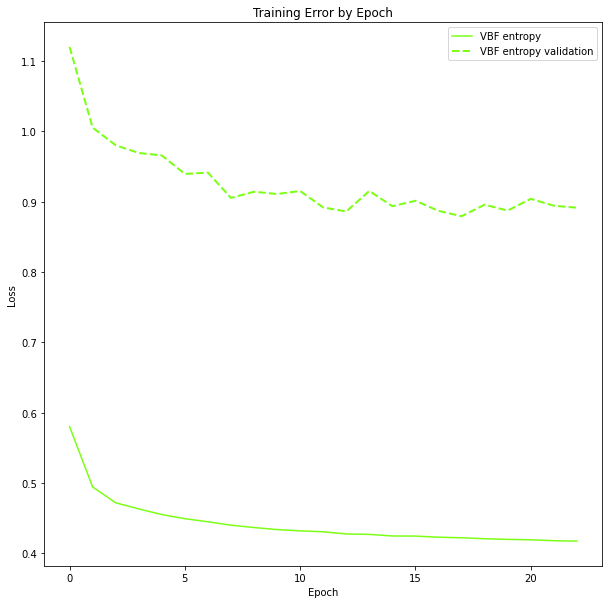

In [21]:
show_losses( [("VBF entropy", hist)])

In [22]:
from sklearn.metrics import roc_curve
y_pred2 = model.predict(x_test)
y_pred = y_pred2.ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred)

In [23]:
from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)

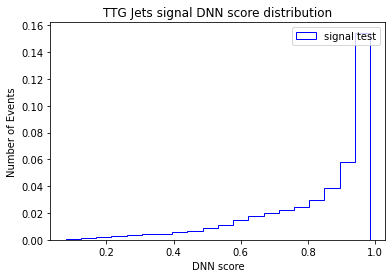

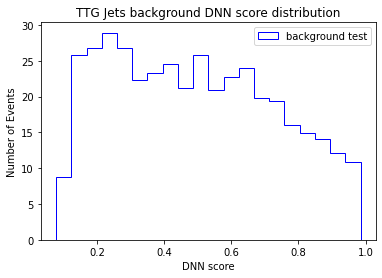

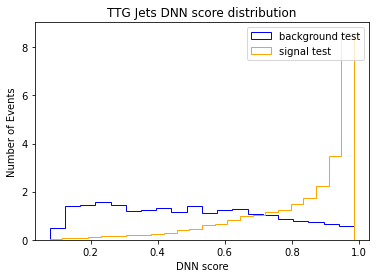

In [25]:
# Plot DNN score distribution

bgd = y_pred[y_test == 0]
sgl = y_pred[y_test == 1]
sgl_weight = test_weight[y_test == 1].flatten()
bgd_weight = test_weight[y_test == 0].flatten()

plt.hist(sgl, color='blue', weights= sgl_weight, histtype='step', bins = 20, label= 'signal test')
plt.xlabel('DNN score')
plt.ylabel('Number of Events')
#plt.vlines(0.55, ymin=0, ymax = 0.10, color = 'orange')
plt.legend(loc = 'best')
plt.title(names[i] + ' signal DNN score distribution')
plt.savefig(fname = f'DNN_Score_Plts/2018/{names[i]}_xpt_2018_mass_sig_score.png', format='png')
plt.show()

plt.hist(bgd, color='blue', weights= bgd_weight, histtype='step', bins = 20, label= 'background test')
plt.xlabel('DNN score')
plt.ylabel('Number of Events')
#plt.vlines(0.5, ymin=0, ymax = 10, color = 'orange')
plt.legend(loc = 'best')
plt.title(names[i] + ' background DNN score distribution')
plt.savefig(fname = f'DNN_Score_Plts/2018/{names[i]}_xpt_2018_mass_bkg_score.png', format='png')
plt.show()

plt.hist(bgd, color='blue', weights= bgd_weight, histtype='step', bins = 20, label= 'background test', density=True)
plt.hist(sgl, color='orange', weights= sgl_weight, histtype='step', bins = 24, label= 'signal test', density=True)
plt.xlabel('DNN score')
plt.ylabel('Number of Events')
plt.legend(loc = 'best')
plt.title(names[i] + ' DNN score distribution')
plt.savefig(fname = f'DNN_Score_Plts/2018/{names[i]}_xpt_2018_mass_score.png', format='png')
plt.show()

In [26]:
bgd_x_all = x_all_test[y_test == 0]
bgd_y = y_pred[y_test == 0]
bgd_test = y_test[y_test == 0]

sig_x_all = x_all_test[y_test == 1]
sig_y = y_pred[y_test == 1]
sig_test = y_test[y_test == 1]

result_sig_df = pd.DataFrame(sig_x_all, columns = list(sig_df.columns))
result_sig_df[b'genweight_scale'] = result_sig_df.loc[:, b'genweight'].values * scale_sig
result_sig_df[b'DNN score'] = sig_y
result_bgd_df = pd.DataFrame(bgd_x_all, columns = list(bkg_df.columns))
result_bgd_df[b'genweight_scale'] = result_bgd_df.loc[:, b'genweight'].values * scale_bgd
result_bgd_df[b'DNN score'] = bgd_y

In [27]:
# make copy of dataframe

result_sig_df_alt = pd.DataFrame()
result_bgd_df_alt = pd.DataFrame()
for column in list(result_sig_df.columns):
    result_sig_df_alt[column] = result_sig_df.loc[:, column].values
    result_bgd_df_alt[column] = result_bgd_df.loc[:, column].values

In [28]:
result_sig_df_alt.head()

,b'leading_photon_eta',b'leading_photon_phi',b'subleading_photon_eta',b'subleading_photon_phi',b'leading_bjet_eta',b'leading_bjet_phi',b'subleading_bjet_eta',b'subleading_bjet_phi',b'leadingDeepBscore',b'subleadingDeepBscore',b'sumDeepBscore',b'leading_pho_pt_over_dimass',b'leading_bjet_pt_over_dimass',b'leading_bjet_pt_over_dimass_corr',b'genweight',b'dibjet_mass',b'diphoton_mass',b'event',b'genweight_scale',b'DNN score'
0,1.984375,-1.116699,2.162109,0.935791,0.284241,2.477539,0.258545,-1.483154,0.998535,0.984863,1.983398,0.673434,0.765990,0.783410,0.000016,125.572731,123.048927,25169.0,0.000082,0.909722
1,-0.150299,-0.147827,0.225037,-1.257324,0.828613,-2.631836,0.302185,2.571777,0.584961,0.894043,1.479004,1.146850,1.375318,1.563455,0.000016,112.337646,124.366524,30692.0,0.000082,0.969741
2,-0.301514,0.886841,-0.937866,1.768066,0.376465,-1.268799,-0.889893,-1.675781,0.978027,0.933105,1.911133,1.044633,0.816741,0.848291,0.000028,104.301689,123.043556,11985.0,0.000139,0.935100
3,1.412354,-1.087646,-0.015104,-0.003485,-1.239990,1.561523,-1.206787,2.262207,0.998535,0.996582,1.995117,0.957519,1.797073,0.911693,0.000016,26.779665,121.138084,40655.0,0.000082,0.972768
4,-0.352661,-1.972656,-0.026932,2.085449,-0.813232,0.291687,-1.909424,2.053711,0.999023,0.999023,1.998047,1.059617,0.524853,0.529115,0.000019,115.151329,124.115471,44320.0,0.000095,0.730880


In [29]:
result_bgd_df_alt.head()

,b'leading_photon_eta',b'leading_photon_phi',b'subleading_photon_eta',b'subleading_photon_phi',b'leading_bjet_eta',b'leading_bjet_phi',b'subleading_bjet_eta',b'subleading_bjet_phi',b'leadingDeepBscore',b'subleadingDeepBscore',b'sumDeepBscore',b'leading_pho_pt_over_dimass',b'leading_bjet_pt_over_dimass',b'leading_bjet_pt_over_dimass_corr',b'genweight',b'dibjet_mass',b'diphoton_mass',b'event',b'genweight_scale',b'DNN score'
0,0.472046,2.038086,-0.918579,-2.730957,0.234497,-1.263672,-1.668701,2.327148,0.834473,0.935547,1.770020,0.744439,0.461907,0.645969,-0.031315,127.798950,132.548523,16650747.0,-0.155585,0.305181
1,1.045166,-0.533813,0.336975,-0.749390,1.220459,2.146973,0.768066,-1.225342,0.999512,0.344727,1.344238,0.549727,0.734613,0.592648,0.060774,101.839272,111.323769,814179.0,0.301945,0.483754
2,-2.131836,-0.979614,-0.541382,-2.035645,1.624512,-0.315002,-1.671875,1.681641,0.999023,0.997070,1.996094,0.963465,0.205566,0.554451,-0.031315,195.648621,111.585426,3722493.0,-0.155585,0.533092
3,-1.417725,1.235840,-1.418701,-0.713013,-1.997070,-0.029179,1.210938,-2.229980,0.777344,0.248047,1.025391,0.650696,0.309061,0.812602,-0.031315,398.990540,109.237747,5587422.0,-0.155585,0.243778
4,-0.574097,0.433411,-0.270264,-1.698730,-1.447510,1.251953,-0.268066,2.753906,0.315918,0.138916,0.454834,0.700917,0.703888,0.658073,-0.031315,77.293861,125.393974,14806826.0,-0.155585,0.538648


In [30]:
from ROOT import RDF
from ROOT import Internal

result_sig_dict = {key.decode("utf-8"): result_sig_df_alt[key].values for key in list(result_sig_df_alt.columns)}
result_bgd_dict = {key.decode("utf-8"): result_bgd_df_alt[key].values for key in list(result_bgd_df_alt.columns)}
sig_rdf = rt.RDF.MakeNumpyDataFrame(result_sig_dict)
bgd_rdf = rt.RDF.MakeNumpyDataFrame(result_bgd_dict)
sig_rdf.Snapshot('tree', f'DNN_Trees/full/{names[i]}_xpt_sig_DNN_file.root')
bgd_rdf.Snapshot('tree', f'DNN_Trees/full/{names[i]}_xpt_bgd_DNN_file.root')

<cppyy.gbl.ROOT.RDF.RResultPtr<ROOT::RDF::RInterface<ROOT::Detail::RDF::RLoopManager,void> > object at 0x6d6094d0>

In [31]:
file_name = f'DNN_Trees/full/{names[i]}_xpt_sig_DNN_file.root'
data_file = uproot.open(file_name)
data_array = data_file['tree'].arrays()
data_df = pd.DataFrame(data_array)
data_df.head()

,b'leading_photon_eta',b'leading_photon_phi',b'subleading_photon_eta',b'subleading_photon_phi',b'leading_bjet_eta',b'leading_bjet_phi',b'subleading_bjet_eta',b'subleading_bjet_phi',b'leadingDeepBscore',b'subleadingDeepBscore',b'sumDeepBscore',b'leading_pho_pt_over_dimass',b'leading_bjet_pt_over_dimass',b'leading_bjet_pt_over_dimass_corr',b'genweight',b'dibjet_mass',b'diphoton_mass',b'event',b'genweight_scale',b'DNN score'
0,1.984375,-1.116699,2.162109,0.935791,0.284241,2.477539,0.258545,-1.483154,0.998535,0.984863,1.983398,0.673434,0.765990,0.783410,0.000016,125.572731,123.048927,25169.0,0.000082,0.909722
1,-0.150299,-0.147827,0.225037,-1.257324,0.828613,-2.631836,0.302185,2.571777,0.584961,0.894043,1.479004,1.146850,1.375318,1.563455,0.000016,112.337646,124.366524,30692.0,0.000082,0.969741
2,-0.301514,0.886841,-0.937866,1.768066,0.376465,-1.268799,-0.889893,-1.675781,0.978027,0.933105,1.911133,1.044633,0.816741,0.848291,0.000028,104.301689,123.043556,11985.0,0.000139,0.935100
3,1.412354,-1.087646,-0.015104,-0.003485,-1.239990,1.561523,-1.206787,2.262207,0.998535,0.996582,1.995117,0.957519,1.797073,0.911693,0.000016,26.779665,121.138084,40655.0,0.000082,0.972768
4,-0.352661,-1.972656,-0.026932,2.085449,-0.813232,0.291687,-1.909424,2.053711,0.999023,0.999023,1.998047,1.059617,0.524853,0.529115,0.000019,115.151329,124.115471,44320.0,0.000095,0.730880


In [32]:
# Bkg reduction
# Bkg reduction
def significance_file(k):
    file.write(f'cutoff: {k}\n')
    bgd = y_pred[y_test == 0]
    file.write(f'# background: {len(bgd)}\n')
    bgd_bin = []
    for event in bgd:
        if event >= k:
            bgd_bin.append(1)
        else:
            bgd_bin.append(0)
    file.write(f'# false signal: {sum(bgd_bin)}\n')

    sgl = y_pred[y_test == 1]
    file.write(f'# signal: {len(sgl)}\n')
    sgl_bin = []
    for event in sgl:
        if event >= k:
            sgl_bin.append(1)
        else:
            sgl_bin.append(0)
    file.write(f'# true signal: {sum(sgl_bin)}\n')
    bgd_bin_np = np.array(bgd_bin)
    sgl_bin_np = np.array(sgl_bin)
    sgl_weight = test_weight[y_test == 1].flatten() * scale_sig
    bgd_weight = test_weight[y_test == 0].flatten() * scale_bgd
    file.write(f'original background: {np.sum(bkg_weight_np_sfl)}\n')
    file.write(f'original test background: {np.sum(bgd_weight)}\n')
    file.write(f'original signal: {np.sum(sig_weight_np_sfl)}\n')
    file.write(f'original test signal: {np.sum(sgl_weight)}\n')

    re_bkg = np.sum(bgd_bin_np * bgd_weight)
    file.write(f'remaining background: {re_bkg}\n')
    re_sig = np.sum(sgl_bin_np * sgl_weight)
    file.write(f'remaining signal: {re_sig}\n')
    file.write(f'original S/sqrt(S+B): {np.sum(sig_weight_np_sfl) / np.sqrt(np.sum(sig_weight_np_sfl) + np.sum(bkg_weight_np_sfl))}\n')
    file.write(f'original test S/sqrt(S+B): {np.sum(sgl_weight) / np.sqrt(np.sum(sgl_weight) + np.sum(bgd_weight))}\n')
    file.write(f'S/sqrt(S+B): {re_sig / np.sqrt(re_sig + re_bkg)}\n')
    file.write('\n')
    return re_sig / np.sqrt(re_sig + re_bkg)

def significance_print(k):
    print(f'cutoff: {k}')
    bgd = y_pred[y_test == 0]
    print(f'# background: {len(bgd)}\n')
    bgd_bin = []
    for event in bgd:
        if event >= k:
            bgd_bin.append(1)
        else:
            bgd_bin.append(0)
    print(f'# false signal: {sum(bgd_bin)}\n')

    bgd = y_pred[y_test == 0]
    print(f'# signal: {len(sgl)}')
    sgl_bin = []
    for event in sgl:
        if event >= k:
            sgl_bin.append(1)
        else:
            sgl_bin.append(0)
    print(f'# true signal: {sum(sgl_bin)}\n')
    bgd_bin_np = np.array(bgd_bin)
    sgl_bin_np = np.array(sgl_bin)
    sgl_weight = test_weight[y_test == 1].flatten() * scale_sig
    bgd_weight = test_weight[y_test == 0].flatten() * scale_bgd
    print(f'original background: {np.sum(bkg_weight_np_sfl)}')
    print(f'original test background: {np.sum(bgd_weight)}')
    print(f'original signal: {np.sum(sig_weight_np_sfl)}')
    print(f'original test signal: {np.sum(sgl_weight)}')

    re_bkg = np.sum(bgd_bin_np * bgd_weight)
    print(f'remaining background: {re_bkg}\n')
    re_sig = np.sum(sgl_bin_np * sgl_weight)
    print(f'remaining signal: {re_sig}\n')
    print(f'original S/sqrt(S+B): {np.sum(sig_weight_np_sfl) / np.sqrt(np.sum(sig_weight_np_sfl) + np.sum(bkg_weight_np_sfl))}\n')
    print(f'original test S/sqrt(S+B): {np.sum(sgl_weight) / np.sqrt(np.sum(sgl_weight) + np.sum(bgd_weight))}\n')
    print(f'S/sqrt(S+B): {re_sig / np.sqrt(re_sig + re_bkg)}\n')
    print('\n')
    return re_sig / np.sqrt(re_sig + re_bkg)

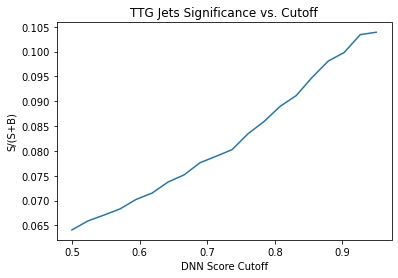

In [33]:
test_sc = np.linspace(0.5, 0.95, 20)
sc_vals = []
file = open('DNN_Score_Nums/full/' + names[i]+'_xpt_mass_DNN_score.txt', "w")
for value in test_sc:
    sc_vals.append(significance_file(value))

file.close()
    
plt.plot(test_sc, sc_vals, label = names[i])
plt.xlabel('DNN Score Cutoff')
plt.ylabel('S/(S+B)')
plt.title(names[i] + ' Significance vs. Cutoff')
plt.savefig(fname = f'DNN_Score_Plts/full/{names[i]}_xpt_mass_significance', format='png')
plt.show()

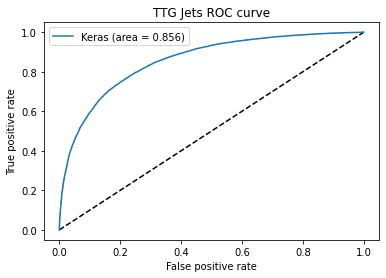

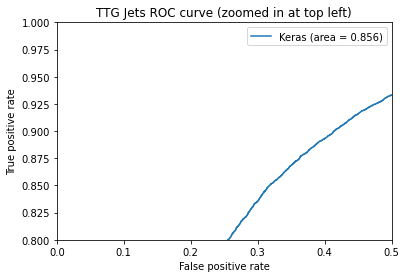

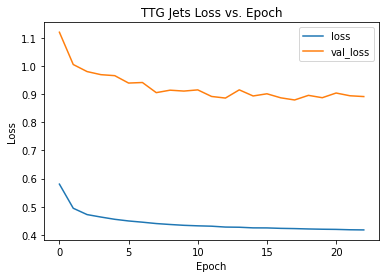

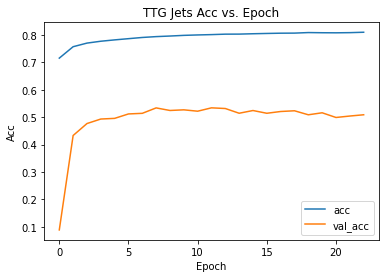

In [34]:
# Plots

# ROC curve
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title(names[i] + ' ROC curve')
plt.legend(loc='best')
plt.savefig(fname = f'ROC_Plts/full/{names[i]}_xpt_mass_ROC_curve.png', format='png')
plt.show()

# Zoom in view of the upper left corner ROC curve
plt.figure(2)
plt.xlim(0, 0.5)
plt.ylim(0.8, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label= 'Keras (area = {:.3f})'.format(auc_keras))
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.title(names[i] + ' ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.savefig(fname = f'ROC_Plts/full/{names[i]}_xpt_mass_ROC_curve_zoom')
plt.show()


# plot loss vs epoch
plt.figure(3)
plt.plot(hist.history['loss'], label='loss')
plt.plot(hist.history['val_loss'], label='val_loss')
plt.legend(loc="best")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title(names[i] + ' Loss vs. Epoch')
plt.savefig(fname = f'Epoch_Plts/full/{names[i]}_xpt_loss_epoch.png', format='png')
plt.show()

# plot accuracy vs epoch
plt.figure(4)
plt.plot(hist.history['accuracy'], label='acc')
plt.plot(hist.history['val_accuracy'], label='val_acc')
plt.legend(loc="best")
plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.title(names[i] + ' Acc vs. Epoch')
plt.savefig(fname = f'Epoch_Plts/full/{names[i]}_xpt_mass_acc_epoch.png', format='png')
plt.show()

In [35]:
file = open('Efficiency/full/' + names[i]+'_xpt_mass_DNN_efficiency.txt', "w")
file.write('1% acceptance\n')
for x in tpr_keras[fpr_keras>=0.009997]:
    if x in tpr_keras[fpr_keras<=0.01]:
        file.write(f'{x}\n')

file.write('\n')

file.write('0.1% acceptance\n')
for y in tpr_keras[fpr_keras>=0.0009997]:
    if y in tpr_keras[fpr_keras<=0.001]:
        file.write(f'{y}\n')
file.close()

In [36]:
def check_mass_gg(label, test_all, var_index, weight_index, dnn_index, label_index, samp):
    samples = ['Background', 'Signal']
    fontsize=25
    TPR_thresholds = [0.8,0.7,0.6, 0.5, 0.4, 0.3,0.2]
    bins = np.linspace(110, 140, 20)
    plt.figure(figsize=(9,6))
    plt.hist(test_all[:,var_index][test_all[:,label_index]==label], bins=bins, weights=test_all[:,weight_index][test_all[:,label_index]==label], density=True, label='No cut')
    for TPR_threshold in TPR_thresholds:
        #print(TPR_threshold)
    
        tmp = test_all[np.where((test_all[:,label_index]==label)*(test_all[:,dnn_index]>TPR_threshold))]
        plt.hist(tmp[:,var_index],
             bins=bins, histtype='step', 
             weights=tmp[:,weight_index], 
             label= "{:.0f}% bkg eff".format(100*TPR_threshold),
             density=True)
    
    plt.legend(loc='best')
    plt.ylabel(samples[label] + ' events (normalized to unit area)',fontsize=12)
    plt.xlabel(r'$m_{\gamma\gamma}$',fontsize=fontsize)
    plt.title(names[samp]+' '+samples[label])
    plt.savefig(fname = f'Mass_Sculpt_Plts/full/{names[samp]}_xpt_mass_gg_mass_sculpt_{samples[label]}')
    
def check_mass_jj(label, test_all, var_index, weight_index, dnn_index, label_index, samp):
    samples = ['Background', 'Signal']
    fontsize=25
    TPR_thresholds = [0.8,0.7,0.6, 0.5, 0.4, 0.3,0.2]
    bins = np.linspace(110, 140, 20)
    plt.figure(figsize=(9,6))
    plt.hist(test_all[:,var_index][test_all[:,label_index]==label], bins=bins, weights=test_all[:,weight_index][test_all[:,label_index]==label], density=True, label='No cut')
    for TPR_threshold in TPR_thresholds:
        #print(TPR_threshold)
    
        tmp = test_all[np.where((test_all[:,label_index]==label)*(test_all[:,dnn_index]>TPR_threshold))]
        plt.hist(tmp[:,var_index],
             bins=bins, histtype='step', 
             weights=tmp[:,weight_index], 
             label= "{:.0f}% bkg eff".format(100*TPR_threshold),
             density=True)
    
    plt.legend(loc='best')
    plt.ylabel(samples[label] + ' events (normalized to unit area)',fontsize=12)
    plt.xlabel(r'$m_{jj}$',fontsize=fontsize)
    plt.title(names[samp]+' '+samples[label])
    plt.savefig(fname = f'Mass_Sculpt_Plts/full/{names[samp]}_xpt_mass_jj_mass_sculpt_{samples[label]}')

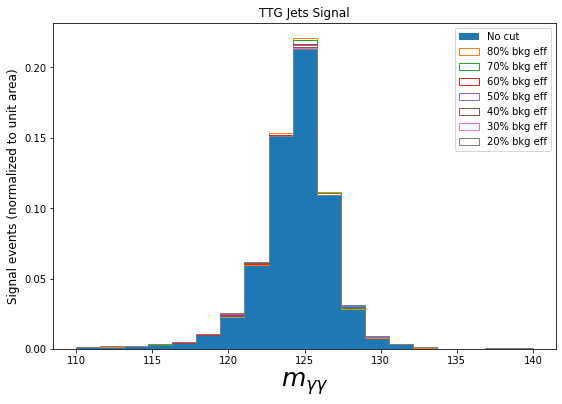

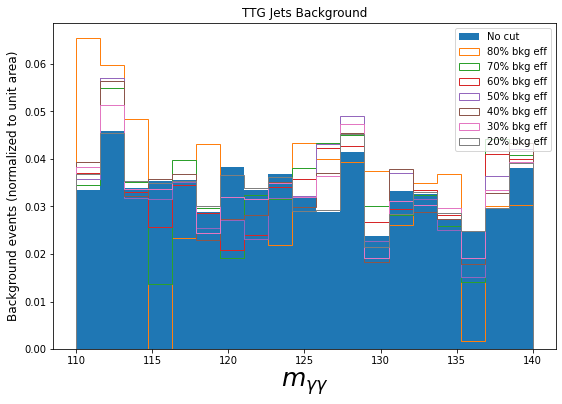

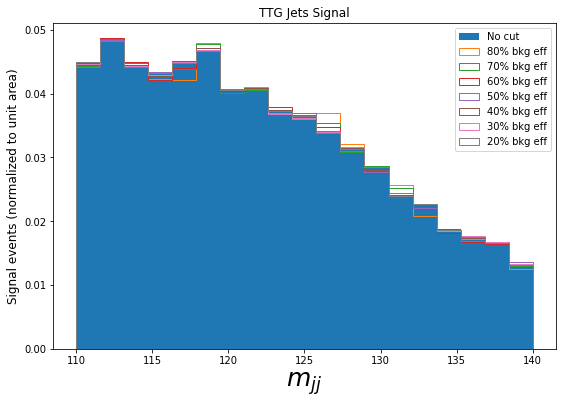

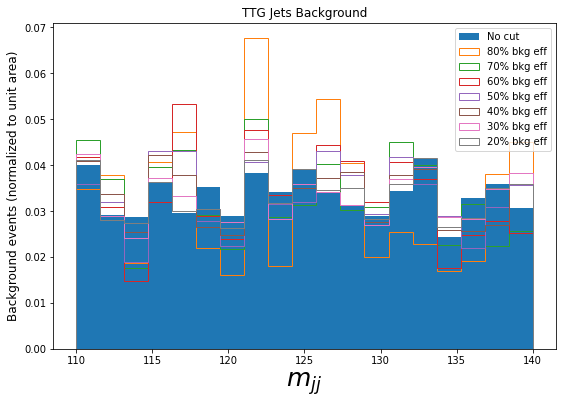

In [37]:
label_test = np.array([y_test]).T
test_all = np.concatenate((x_all_test,y_pred2, label_test), 1)
#signal
check_mass_gg(1, test_all, 16, 14, 18, 19, i)
#bkg
check_mass_gg(0, test_all, 16, 14, 18, 19, i)

#signal
check_mass_jj(1, test_all, 15, 14, 18, 19, i)
#bkg
check_mass_jj(0, test_all, 15, 14, 18, 19, i)

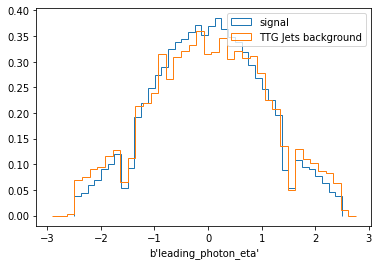

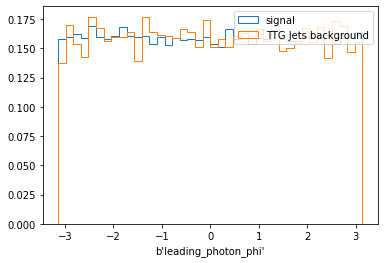

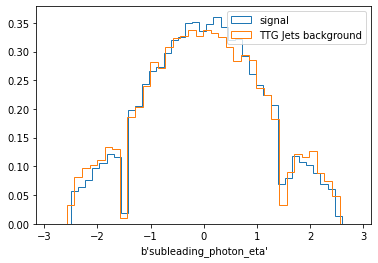

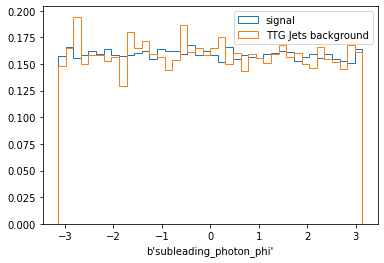

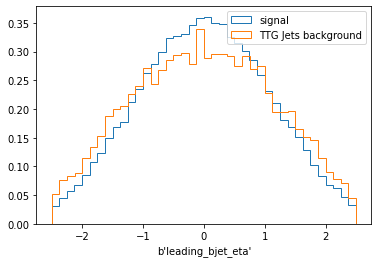

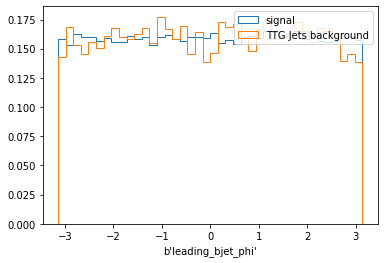

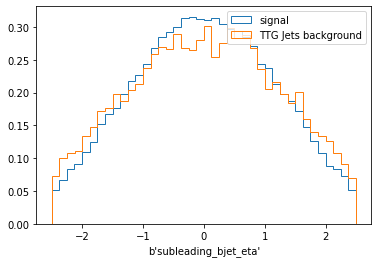

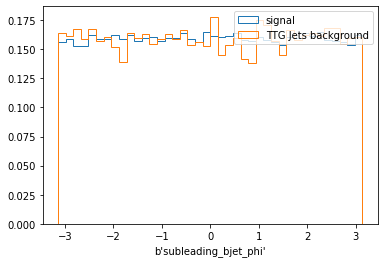

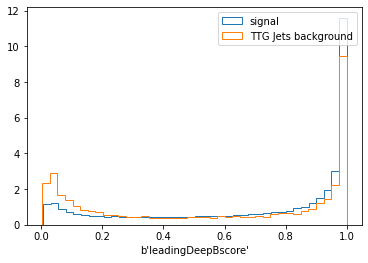

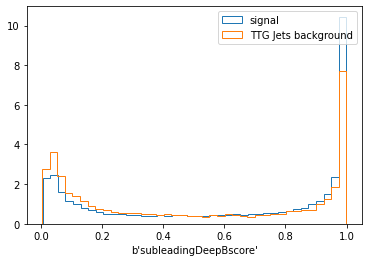

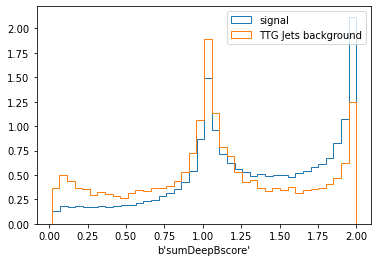

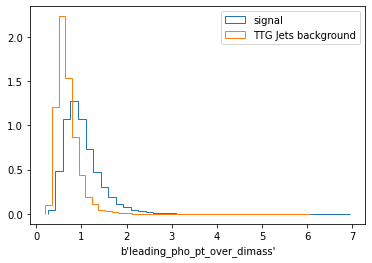

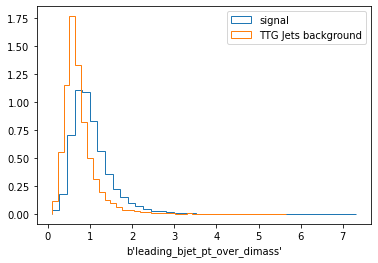

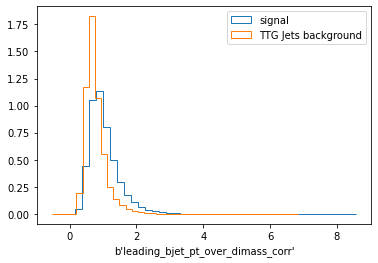

In [38]:
for hlf in training_vars:
    plt.figure()
    plt.hist(sig_df[hlf], bins=40, density=True, weights=sig_df[b'genweight'],
             histtype='step', label='signal')
    plt.hist(bkg_df[hlf], bins=40, density=True, weights=bkg_df[b'genweight'], 
             histtype='step', label= names[i] + ' background')
    plt.xlabel(hlf)
    plt.savefig(fname = f'BackgroundVsSignal_Plts/full/{names[i]}_full_{hlf}')
    plt.legend(loc='best')

# 